In [2]:
import cv2
from evaluate.lane import LaneEval  #算acc用的，格式還沒有做
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import math
import time
import json

# Method 1   (Step by Step)

In [3]:
#good example
filename = 'clips/0530/1492626886710588325_0/14.jpg'

#good example
#filename = 'clips/0530/1492626886710588325_0/14.jpg'
# SoSo
#filename = 'clips/0531/1492626718748019090/2.jpg'
# good 
#filename= 'clips/0531/1492626371522989086/4.jpg'
# SoSo
#filename='clips/0531/1492626271917313999/8.jpg'
# good 
#filename = 'clips/0531/1492627478052569489/17.jpg'
#SoSo
#filename = 'clips/0531/1492627837967873644/4.jpg'
# good 
#filename = 'clips/0531/1492628032250037427/2.jpg'
# SoSo
#filename = 'clips/0531/1492627517664589343/10.jpg'
# 
#bad
#filename = 'clips/0531/1492626327183261694/10.jpg'
# good 
#filename = 'clips/0531/1492626292371547028/5.jpg'
# bad
#filename = 'clips/0531/1492626549851148880/19.jpg'

#google map
#filename= 'googlemap3.jpg'

# medium example
#filename = 'clips/0531/1492626725443010116/2.jpg'

# bad (cross road ) 
#filename = 'clips/0530/1492626127172745520_0/20.jpg'

# bad (car block the sight)
#filename = 'clips/0530/1492634972638999132_0/20.jpg'

# other dataset
#input_img =( mpimg.imread('vlcsnap-2021-06-22-16h33m52s255.png') * 255).astype(np.uint8)

input_img = mpimg.imread(filename)
 
# 有時候會執行錯誤，應該是左右兩類的線段其中一邊是空的
print('This image is:', type(input_img), 'with dimensions:', input_img.shape)
#output_img = lane_img_pipeline(input_img)
#plt.imshow(output_img)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


In [4]:
def grayscale(img):
        """
        grayscale, preprocessing for edge detection
        """
        return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def canny(img,low_threshold=20,high_threshold=50):
        """ Canny Edge detection"""
        return cv2.Canny(img,low_threshold,high_threshold)
    
def region_of_interest(img):
        """
        mask while leave region of interest
        """
        # Define region not mask
        
        imshape = img.shape
        lower_left = [0,imshape[0]]
        lower_right = [imshape[1],imshape[0]]
        middle_left = [0,imshape[0]/3+imshape[0]/5]
        middle_right = [imshape[1],imshape[0]/3+imshape[0]/5]
        top_left = [imshape[1]/3-imshape[1]/7,imshape[0]/3+imshape[0]/10]
        top_right = [imshape[1]/3+imshape[1]/3,imshape[0]/3+imshape[0]/10]
        vertices = [np.array([lower_left,middle_left,top_left,top_right,middle_right,lower_right],dtype=np.int32)]
        '''
        # for white video
        imshape = img.shape
        lower_left = [0,imshape[0]]
        lower_right = [imshape[1],imshape[0]]
        middle_left = [0,imshape[0]/2+imshape[0]/4]
        middle_right = [imshape[1],imshape[0]/2+imshape[0]/4]
        top_left = [imshape[1]/3,imshape[0]/2+imshape[0]/10]
        top_right = [imshape[1]/3+imshape[1]/3,imshape[0]/2+imshape[0]/10]
        vertices = [np.array([lower_left,middle_left,top_left,top_right,middle_right,lower_right],dtype=np.int32)]
        '''
        # Define a blank matrix that matches the image height/width.
        mask = np.zeros_like(img)
        # Retrieve the number of color channels of the image.
        #channel_count = img.shape[2]
        # Create a match color with the same color channel counts.
        #match_mask_color = (255,) * channel_count 
        match_mask_color = 255
        # Fill inside the polygon
        cv2.fillPoly(mask, vertices, match_mask_color)
        #mask，ROI region reveal，other conceal
        masked_image = cv2.bitwise_and(img, mask) 
        return masked_image

# for tusimple    
def hough_lines(img,rho=3,theta=np.pi/180,threshold=60,min_line_len=100,max_line_gap=100):

# for white video
#def hough_lines(img,rho=3,theta=np.pi/180,threshold=60,min_line_len=100,max_line_gap=100):

        """
        将canny边缘检测后的像素点连接成线，并调用划线函数，返回画线的图片
        hough transform原理：转换到 hough space,r,θ极坐标，正弦曲线，
        每条线代表个image space中过一点的所有线，
        lines的交点代表共线，找到交点再返回到image space空间
        lines:[[x1,y1,x2,y2],[x x y y]...]
        """
        lines=cv2.HoughLinesP(img,rho,theta,threshold, np.array([]), 
                              minLineLength=min_line_len, maxLineGap=max_line_gap)
        return lines
    
def draw_lines(img,lines,color=[255,0,0],thickness=3,cal_slope=True):
        """ draw line segments on image , and return slope and x-bias for the  segments if `cal_slope = True`"""
        if cal_slope:
            theta = []
            bias_x = []
        if lines is None:
            return
        img=np.copy(img)
        
        img_channels=img.shape[2]
        line_img=np.zeros((img.shape[0],img.shape[1],img_channels),dtype=np.uint8)
        
        for line in lines:
            for x1,y1,x2,y2 in line:
            
                if cal_slope:
                    
                    th = math.atan2(y2-y1, x2-x1)
                    theta.append(th)
                    
                    slope = (y2-y1)/(x2-x1)

                    # calculate x off_set at line y = 700
                    bias = x1-(y1-400 / slope)
                    if math.isinf(bias):
                        bias = math.copysign(1e7,bias)
                    bias_x.append(bias)

                cv2.line(line_img,(x1,y1),(x2,y2),color,thickness)
        
        img=cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) 

        if cal_slope:
            return img, np.array(theta), np.array(bias_x)
        else:
            return img
    
def group_lines_and_draw(img,lines,k,label,return_polys=False):
        x = [[] for _ in range(k)]
        y = [[] for _ in range(k)]    
        
        for idx, line in enumerate(lines):
            for x1,y1,x2,y2 in line:
                
                x[int(label[idx])].extend([x1,x2])
                y[int(label[idx])].extend([y1,y2])
        # for tusimple 
        min_y=int(img.shape[0]*(1/3+1/20))
        # for white video
        #min_y=int(img.shape[0]*(1/2 + 1/10))

        max_y=int(img.shape[0])
        
        polys = []
        draw = []
        img = img.copy()
        for i in range(k):
            poly = np.poly1d(np.polyfit(y[i],x[i],deg=1))
            polys.append(poly)
            x_start = int(poly(max_y))
            x_end = int(poly(min_y))
            draw.append([x_start,max_y,x_end,min_y])
        draw = np.expand_dims(draw,axis=1)
        line_image=draw_lines(img,draw,thickness=10,cal_slope=False)
        
        
        if return_polys:
            return line_image, polys                                                                                                                                                                                                                                                                                                                                                                                                                                                            
        return line_image


([], [])

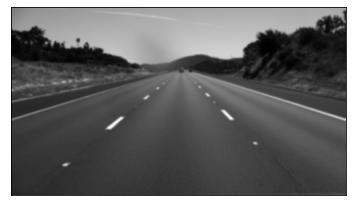

In [5]:
gray_img=grayscale(input_img)

kernel_size = 15

gray_img = gaussian_blur(gray_img, kernel_size)
plt.imshow(gray_img,cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.colorbar()


([], [])

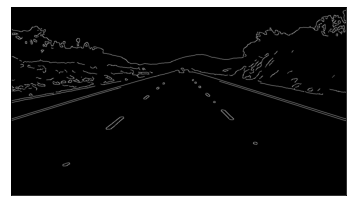

In [6]:
canny_img=canny(gray_img,low_threshold=20,high_threshold=50)
# Gaussian blur
kernel_size = 3
blur_gray = gaussian_blur(canny_img, kernel_size)
plt.imshow(blur_gray,cmap='gray')
plt.xticks([])
plt.yticks([])

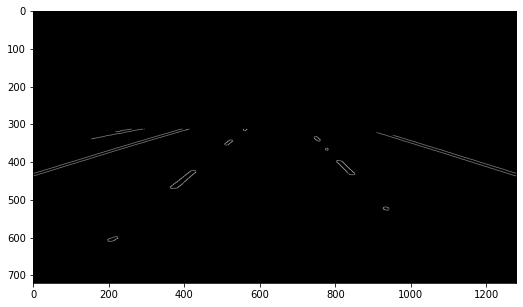

In [7]:
ROI_img=region_of_interest(canny_img)
f ,ax  = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.imshow(ROI_img,cmap='gray')  

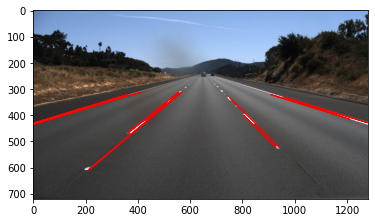

In [8]:


lines=hough_lines(ROI_img,rho=3,theta=np.pi/180,threshold=60,min_line_len=80,max_line_gap=300)

# get rid off lines with abs slope less than 0.5
def filter_line(lines):
    survive = []
    for l in lines:
        for x1, y1, x2, y2 in l:
            slope = (y2-y1)/(x2-x1)
            if abs(slope) > 0.1 and (x1-x2)**2 + (y1-y2)**2 > 25000:
                survive.append(l)

    return survive


lines = filter_line(lines)
line_img,slope, bias_x=draw_lines(input_img,lines)
plt.imshow(input_img)  
for l in lines:
    for x1,y1,x2,y2 in l:
        plt.arrow(x1,y1,x2-x1,y2-y1,color='r',linewidth=1)

Text(0, 0.5, 'normalized x bias')

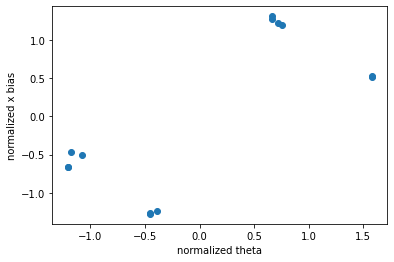

In [9]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean) / std
slope = standardize(slope)
bias_x = standardize(bias_x)
plt.scatter(slope,bias_x)
plt.xlabel('normalized theta')
plt.ylabel('normalized x bias')

In [10]:
num_lines = 4

In [11]:
def Kmeans(slope):
    kmeans = KMeans(n_clusters=num_lines, random_state=1,n_init=100).fit(slope)
    return kmeans.labels_
label = Kmeans(np.stack([slope,bias_x],axis=1))

Text(0, 0.5, 'normalized x bias')

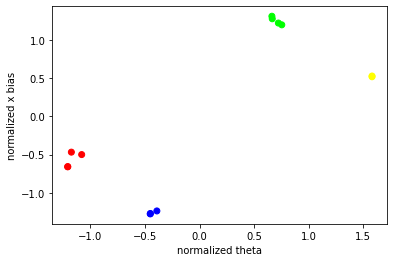

In [12]:
colors = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0],[1.0,1.0,0]])[label]

plt.scatter(slope,bias_x,c = colors)
plt.xlabel('normalized theta')
plt.ylabel('normalized x bias')



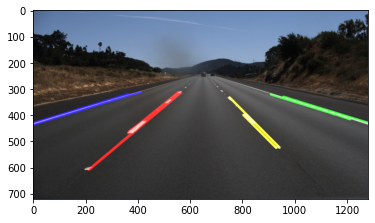

In [13]:

line_img=np.zeros((input_img.shape[0],input_img.shape[1],3),dtype=np.uint8)
for  i, l in enumerate(lines):
    for x1,y1,x2,y2 in l:
      
        cv2.line(line_img,(x1,y1),(x2,y2),color=colors[i]*255,thickness=8)

        
line_sort_img=cv2.addWeighted(input_img, 0.8, line_img, 1.0, 0.0)
plt.imshow(line_sort_img) 

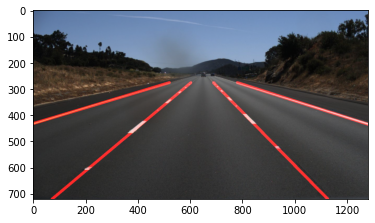

In [14]:
final_image=group_lines_and_draw(input_img,lines,num_lines,label)
plt.imshow(final_image)

# Method 1 (Pipeline)

In [15]:


def pipeline(input_img, plot_k_means = True,return_x_samples=False,h_vals = None):
   

    # 1. gray scale
    gray_img=grayscale(input_img)
    
    # for tusimple 
    #kernel_size = 15
    #kernel_size = 21

    # for white video
    kernel_size = 15

    gray_img = gaussian_blur(gray_img, kernel_size)

    #3. canny
    #low_threshold = 75
    #high_threshold = 150
    canny_img=canny(gray_img)
    #plt.imshow(edges, cmap='Greys_r')
    
    #2. Gaussian Smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(canny_img, kernel_size)
    
    #4. masked
    ROI_img=region_of_interest(blur_gray)
    

    #5. Hough transform
    lines=hough_lines(ROI_img)
    def filter_line(lines):
        survive = []
        for l in lines:
            for x1, y1, x2, y2 in l:
                slope = (y2-y1)/(x2-x1)
                if abs(slope) > 0.2 and (x1-x2)**2 + (y1-y2)**2 > 25000:
                    survive.append(l)

        return survive
    


    lines = filter_line(lines)
    line_img, theta, bias_x=draw_lines(input_img,lines)
    def standardize(img):
        mean = np.mean(img)
        std = np.std(img)
        return (img - mean) / std
    theta = standardize(theta) * 10
    bias_x = standardize(bias_x)    
    
    try:
        label = Kmeans(np.stack([theta, bias_x],axis=1))
    except:
        print(f'Kmeans Error: with theta = \n{theta}\n bias_x = \n{bias_x}\n ')
        raise("error!! haha")


    colors = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0],[1.0,1.0,0]])[label]
    line_img=np.zeros((input_img.shape[0],input_img.shape[1],3),dtype=np.uint8)
    for  i, l in enumerate(lines):
        for x1,y1,x2,y2 in l:
            
            cv2.line(line_img,(x1,y1),(x2,y2),color=colors[i]*255,thickness=8)

        
    line_sort_img=cv2.addWeighted(input_img, 0.8, line_img, 1.0, 0.0)   

    if return_x_samples:
        final_image, polys=group_lines_and_draw(input_img,lines,num_lines,label,return_polys=True)
    else :
        final_image=group_lines_and_draw(input_img,lines,num_lines,label)
    k_means_image = None
    if plot_k_means:
        # Make Plot k-means result
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(theta,bias_x,c = colors)
        ax.set_xlabel('normalized theta')
        ax.set_ylabel('normalized x bias')
        # If we haven't already shown or saved the plot, then we need to
        # draw the figure first...
        fig.canvas.draw()
        # Now we can save it to a numpy array.
        k_means_image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep=   '')
        k_means_image = k_means_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))   
        k_means_image = cv2.resize(k_means_image, (final_image.shape[1],final_image.shape[0]))

    # tusimple 
    min_y = int(input_img.shape[0]*(1/3+1/20))

    #white imgae
    #min_y=int(input_img.shape[0]*(2/5))
    
    max_y=int(input_img.shape[0])
    lanes = [[],[],[],[]]
    if return_x_samples:
        assert h_vals is not None , "h_val needed for return x_samples of lanes"
        for i,p in enumerate(polys):
            for h in h_vals:
                if h < min_y or h > max_y:
                    lanes[i].append(-2)
                else:
                    pred_x = polys[i](h)
                    if pred_x < 0 or pred_x > input_img.shape[1]:
                        lanes[i].append(-2)
                    else:
                        lanes[i].append(pred_x)
        return line_sort_img,final_image,k_means_image, lanes
    return line_sort_img, final_image, k_means_image
    

## test pipeline

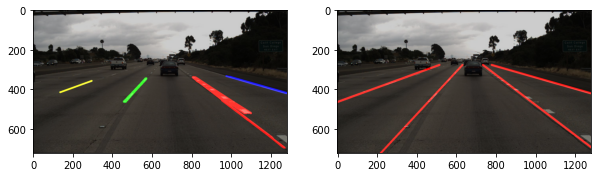

In [16]:
input_img = mpimg.imread('clips/0601/1494452391590105691/11.jpg')
linear , final, _ =  pipeline(input_img, plot_k_means=False, return_x_samples= False)
f,ax = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
ax[0].imshow(linear)
ax[1].imshow(final)

## Process clips and save result as Video

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip, concatenate_videoclips
from IPython.display import HTML
import glob

In [18]:
def process_image(get_frame,time,add_file_name = False):
    
    
    image = get_frame(time)
    line_sort, final, k_means = pipeline(image,plot_k_means=False)
    #result = np.concatenate([line_sort,final],axis=1)
    result = final

    if add_file_name:
        
        frame_number = math.floor(time * 15)
        file_name = file[frame_number//20]
        image_name = str(frame_number%20)
        text = 'clips/0530/'+file_name+'/'+image_name+'.jpg'
        cv2.putText(result, text,[100,100],fontFace = cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=[255,0,0],thickness = 2,lineType=cv2.LINE_AA)

    
    return result

### ouput videos from tusimple clips

In [144]:
file = ['1492626886710588325_0','1492626888709649298_0','1492626893706409672_0','1492626894705755667_0','1492626896704559322_0']
#file = ['1492627031625585314_0','1492627032622200926_0','1492627045614528253_0','1492627051610632948_0','1492627054611277310_0']
clips = []
for i in file:
    images_list = (glob.glob('clips/0530/'+i+'/*.jpg'))
    images_list = sorted(images_list, key=lambda str: int(str.split('/')[-1].split('.')[0]))
    
    clip = ImageSequenceClip(images_list, fps=15)
    clips.append(clip.fl(process_image))

video = concatenate_videoclips(clips,method='compose')
video.write_videofile('./raw_output_M1.mp4',audio=False)

t:   0%|          | 0/100 [00:00<?, ?it/s, now=None]Moviepy - Building video ./raw_output_M1.mp4.
Moviepy - Writing video ./raw_output_M1.mp4

t:   2%|▏         | 2/100 [00:00<00:23,  4.15it/s, now=None]Kmeans Error: with theta = 
[  5.80385635   5.80715954  -4.61144458  -3.77829908 -11.22169932
  -3.76504673 -11.82799834  13.92560755  13.8960121   13.30517021
  -4.32412215  13.31700395 -11.81506245 -11.1854136   -4.30085681
   5.83946005  -4.60819384  14.21211122  -4.55191646 -10.59312364
   6.13890523 -11.51869096 -11.5343759  -11.78864213  13.90941274
  13.9236786  -11.21097299  14.21211122  -3.78119348 -11.78019928
   5.87607299   6.09724668  13.31739309  -3.76246771   6.10138445
 -11.49805664  -4.04092647  13.60475875 -11.78864213]
 bias_x = 
[ 1.5532081   1.52940202 -1.23842046 -1.40271272 -0.45655189 -1.29916554
 -0.41433547  0.68587039  0.68389293  0.71447887 -1.2526936   0.71246332
 -0.41254355 -0.45736146 -1.29997255  1.52718955 -1.23749636  0.67770331
 -1.23595619 -0.4419816

TypeError: exceptions must derive from BaseException

### output video from another video file 

In [458]:
white_output = 'test_videos_output/solidWhiteRight_M1.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight_M1.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_M1.mp4


t:   2%|▏         | 5/221 [20:17:06<01:19,  2.72it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_M1.mp4
CPU times: user 1min 20s, sys: 123 ms, total: 1min 20s
Wall time: 1min 26s


# Test Accurcy 
## Single image

In [19]:
ground_truth = [json.loads(line) for  line in open('jsons/test_label.json').readlines()]

In [20]:
### find test_image by index
gt_index = 125
gt = ground_truth[gt_index]
image_file_path = gt['raw_file']
gt_lanes = gt['lanes']
gt_hs = gt['h_samples']
test_img = cv2.imread(image_file_path)


duration=0.5377182960510254


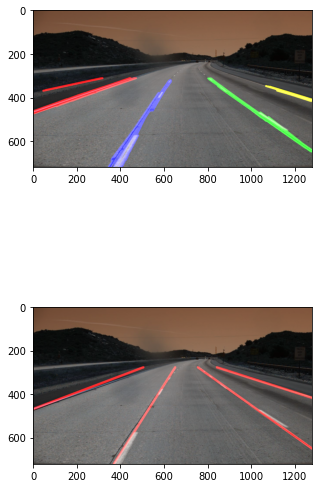

In [21]:
start_t = time.time()
line_sort, final,k_means , lane_pred= pipeline(test_img,plot_k_means=False, return_x_samples=True,h_vals=gt_hs)
end_t = time.time()

print(f'duration={end_t - start_t}')
f,ax = plt.subplots(2,1)
f.set_figheight(10)
f.set_figwidth(5)
ax[0].imshow(line_sort)
ax[1].imshow(final)

In [22]:
acc, fp, fn = LaneEval.bench(lane_pred, gt_lanes, gt_hs,200)
print(f'acc={acc:>4}, fp={fp}, fn={fn}')

acc=0.9553571428571428, fp=0.0, fn=0.0


## Test Accuracy (first 500 test images) 

In [451]:
test_start_index = 0
test_end_index = 500
acc = []
fp = []
fn = []
for i in range(test_start_index,test_end_index):
    print(f'{i}-',end='')
    gt = ground_truth[i]
    image_file_path = gt['raw_file']
    gt_lanes = gt['lanes']
    gt_hs = gt['h_samples']
    test_img = cv2.imread(image_file_path)
    line_sort, final,k_means , lane_pred = pipeline(test_img, plot_k_means=False ,return_x_samples=True,h_vals=np.array(gt_hs))
    acc_i, fp_i, fn_i = LaneEval.bench(lane_pred, gt_lanes, gt_hs,200)
    acc.append(acc_i)
    print(acc_i, image_file_path)
    fp.append(fp_i)
    fn.append(fn_i)

print('')
print(f'Acc mean = {np.mean(np.array(acc))}')
print(f'FP mean = {np.mean(np.array(fp))}')
print(f'FN mean = {np.mean(np.array(fn))}')


/0530/1492626660847529842_0/20.jpg
182-0.6726190476190476 clips/0530/1492626333048395643_0/20.jpg
183-0.9642857142857144 clips/0530/1492626974659207042_0/20.jpg
184-0.3452380952380953 clips/0530/1492626510939139979_0/20.jpg
185-0.5267857142857143 clips/0530/1492626988650418067_0/20.jpg
186-0.75 clips/0530/1492627163542737719_0/20.jpg
187-0.8258928571428572 clips/0530/1492626756789374886_0/20.jpg
188-0.8883928571428572 clips/0530/1492627315450775468_0/20.jpg
189-0.65625 clips/0530/1492626996647452597_0/20.jpg
190-0.8616071428571428 clips/0530/1492627051610632948_0/20.jpg
191-0.7321428571428571 clips/0530/1492626795765899208_0/20.jpg
192-0.8973214285714286 clips/0530/1492627024628422609_0/20.jpg
193-0.2633928571428571 clips/0530/1492627118570353815_0/20.jpg
194-0.8392857142857143 clips/0530/1492627045614528253_0/20.jpg
195-0.9196428571428572 clips/0530/1492627289466433533_0/20.jpg
196-0.825892857142857 clips/0530/1492626731804471304_0/20.jpg
197-0.8080357142857142 clips/0530/149262732344